# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# magic word for producing visualizations in notebook
%matplotlib inline
# eliminate warnings for readability purposes
warnings.filterwarnings('ignore')
'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.shape

(891221, 85)

In [4]:
feat_info.shape

(85, 4)

In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [6]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [7]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [8]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

approach:
for each attribute in feat_info:
for each attribute value that is the same as the 
azdias column name:
check to see if any rows have a value equal to the missing_or_unknown value for the corresponding feat_info row.



In [9]:
# make a copy of dataframe for data wrangling steps
azdias_clean = azdias.copy()

In [10]:
# code to convert string to list
test_list = []
for i in feat_info.missing_or_unknown[0][1:-1].split(','):
    test_list.append(i)
test_list    # test my code

['-1', '0']

In [11]:
# Loop through pairs of attributes and corresponding missing value strings in feat_info to convert strings into lists
for attribute, missing_val in zip(feat_info.attribute, feat_info.missing_or_unknown):
    # for each attribute, instantiate a list to hold converted strings of missing values
    missing_list = []
    # Loop through string and add each item to list
    for i in missing_val[1:-1].split(','):
        missing_list.append(i)
        # now for each matching attribute in azdias compare row value to list of missing values from feat_info
        # if matches, convert to NAN
        azdias_clean.loc[azdias_clean['{}'.format(attribute)].isin(missing_list), '{}'.format(attribute)]=np.NaN

In [12]:
# Let's see if expected values were converted via quick visual check
feat_info[['attribute', 'missing_or_unknown']]

,attribute,missing_or_unknown
0,AGER_TYP,"[-1,0]"
1,ALTERSKATEGORIE_GROB,"[-1,0,9]"
2,ANREDE_KZ,"[-1,0]"
3,CJT_GESAMTTYP,[0]
4,FINANZ_MINIMALIST,[-1]
5,FINANZ_SPARER,[-1]
6,FINANZ_VORSORGER,[-1]
7,FINANZ_ANLEGER,[-1]
8,FINANZ_UNAUFFAELLIGER,[-1]
9,FINANZ_HAUSBAUER,[-1]


In [13]:
# Check before values for 'CAMEO_INTL_2015'
azdias.loc[azdias['{}'.format('CAMEO_INTL_2015')].isin([-1,'XX'])].head().CAMEO_INTL_2015

2511     XX
4569     XX
9803     XX
16700    XX
16883    XX
Name: CAMEO_INTL_2015, dtype: object

In [14]:
# Check after values
azdias_clean.loc[azdias['{}'.format('CAMEO_INTL_2015')].isin([-1,'XX'])].head().CAMEO_INTL_2015

2511     NaN
4569     NaN
9803     NaN
16700    NaN
16883    NaN
Name: CAMEO_INTL_2015, dtype: object

In [15]:
# expected values were converted to NAN!

In [16]:
# all values are numbers now, so we could convert type to Float to be consistent w/ other such columns
azdias_clean.CAMEO_INTL_2015.unique()

array([nan, '51', '24', '12', '43', '54', '22', '14', '13', '15', '33',
       '41', '34', '55', '25', '23', '31', '52', '35', '45', '44', '32'], dtype=object)

In [17]:
type(azdias_clean.ALTERSKATEGORIE_GROB[26])

numpy.float64

In [18]:
# However, there still appears to be some values that are not numbers??
azdias_clean.OST_WEST_KZ.unique()

array([nan, 'W', 'O'], dtype=object)

In [19]:
azdias.OST_WEST_KZ.unique()

array([nan, 'W', 'O'], dtype=object)

Let's go through each column to see which can be converted to Float/Int datatypes
columns that are currently strings: 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015'

In [20]:
azdias_clean['CAMEO_DEU_2015'].unique()

array([nan, '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D',
       '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C'], dtype=object)

In [21]:
azdias_clean['CAMEO_DEUG_2015'].unique()

array([nan, '8', '4', '2', '6', '1', '9', '5', '7', '3'], dtype=object)

In [22]:
azdias_clean['CAMEO_INTL_2015'].unique()

array([nan, '51', '24', '12', '43', '54', '22', '14', '13', '15', '33',
       '41', '34', '55', '25', '23', '31', '52', '35', '45', '44', '32'], dtype=object)

So it looks like OST_WEST_KZ and CAMEO_DEU_2015 can't be converted to a number data type, but CAMEO_DEUG_2015 and CAMEO_INTL_2015 can be converted

In [23]:
azdias_clean.CAMEO_DEUG_2015 = azdias_clean.CAMEO_DEUG_2015.astype('Float64')
azdias_clean.CAMEO_INTL_2015 = azdias_clean.CAMEO_INTL_2015.astype('Float64')

In [24]:
azdias_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 205378 non-null float64
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null float64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null float64
FINANZ_SPARER            891221 non-null float64
FINANZ_VORSORGER         891221 non-null float64
FINANZ_ANLEGER           891221 non-null float64
FINANZ_UNAUFFAELLIGER    891221 non-null float64
FINANZ_HAUSBAUER         891221 non-null float64
FINANZTYP                891221 non-null float64
GEBURTSJAHR              498903 non-null float64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null float64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMI

In [25]:
# check for any remaining columns w/ zero or negative values 
for col in azdias_clean.columns.values:
    if azdias_clean[col].isin([-1,0]).any():
        print(col)

GREEN_AVANTGARDE
SHOPPER_TYP
SOHO_KZ
ANZ_PERSONEN
ANZ_TITEL
ANZ_HH_TITEL
WOHNLAGE
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
ONLINE_AFFINITAET
KBA13_ANZAHL_PKW
PLZ8_ANTG1
PLZ8_ANTG2
PLZ8_ANTG3
PLZ8_ANTG4


#### Analysis: 
Besides for the feature WOHNLAGE, all other features with zero or negative values listed above are as expected in that the feature is either a binary feature like GREEN_AVANTGARDE (0 = not a member, 1 = member), SOHO_KZ (0 = no small/home office, 1 = small/home office) OR that a zero value is consistent with the direction of scale (e.g. low to high or high to low) for that feature and type (e.g. person-level/household-level/building-level/RR4 micro-cell/RR3 micro-cell/Postcode-level/RR1 neighborhood/plz8 macro-cell/community-level feature)
As for WOHNLAGE, the zero value signifies "no score calculated" but instead should be NAN instead because it is inconsistent with the direction of scale for this feature (i.e. the lower the score, the higher the rating usually).  I will be replacing this with NAN.
WOHNLAGE: Neighborhood quality (or rural flag)
-  0: no score calculated --> should be NAN instead
-  1: very good neighborhood
-  2: good neighborhood
-  3: average neighborhood
-  4: poor neighborhood
-  5: very poor neighborhood
-  7: rural neighborhood
-  8: new building in rural neighborhood

In [26]:
# Replacement step
azdias_clean.loc[azdias_clean.WOHNLAGE.isin([0]), 'WOHNLAGE'] = np.NAN

In [27]:
# confirm replacements
azdias_clean.WOHNLAGE.unique()

array([ nan,   4.,   2.,   7.,   3.,   5.,   1.,   8.])

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

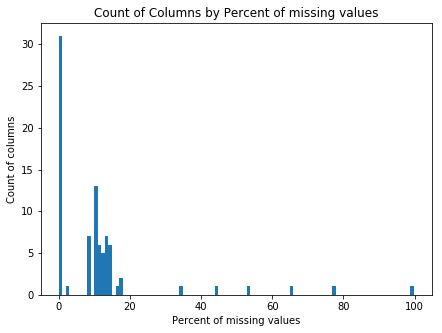

In [28]:
plt.figure(figsize = (7,5))
plt.hist(azdias_clean.isna().mean()*100, bins=100)
plt.title("Count of Columns by Percent of missing values")
plt.xlabel("Percent of missing values")
plt.ylabel("Count of columns");

In [29]:
# Investigate patterns in the amount of missing data in each column.
azdias_clean.isna().mean().sort_values(ascending=False).head(10)

TITEL_KZ          0.997576
AGER_TYP          0.769554
KK_KUNDENTYP      0.655967
KBA05_BAUMAX      0.534687
GEBURTSJAHR       0.440203
ALTER_HH          0.348137
REGIOTYP          0.177357
KKK               0.177357
W_KEIT_KIND_HH    0.166051
KBA05_ANTG4       0.149597
dtype: float64

In [30]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
# There are 85 columns total, of which only 6 columns are missing 35% (34.8%) or more of their values.
# So we'll remove these 6 columns

In [31]:
# Get list of offending 6 columns
azdias_clean.isna().mean().sort_values(ascending=False).head(6).index

Index(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR',
       'ALTER_HH'],
      dtype='object')

In [32]:
# Removal of 6 outlier columns with extremely high percentages of missing values
azdias_clean.drop(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR',
       'ALTER_HH'], axis=1, inplace=True)

In [33]:
# let's make a copy of feat_info with these values also dropped so as to avoid confusion later
feat_clean = feat_info.copy()

feat_clean.drop(feat_clean[feat_clean.attribute.isin(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR',
       'ALTER_HH'])].index, inplace=True)
# let's reset the index to account for removed rows
feat_clean.reset_index(drop=True, inplace=True)
feat_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 4 columns):
attribute             79 non-null object
information_level     79 non-null object
type                  79 non-null object
missing_or_unknown    79 non-null object
dtypes: object(4)
memory usage: 2.5+ KB


#### Discussion 1.1.2: Assess Missing Data in Each Column

The following 6 columns had ~35% or more of their values missing:'TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR','ALTER_HH', which is disproportionately high compared to the 79 other columns in the dataset as per the histogram above.  The vast majority of columns have <18% of their data missing.  As such, these 6 columns appear to be outliers and were removed.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [34]:
# test code for calculating percent of null values for a single row
azdias_clean.iloc[0,:].isnull().mean()

0.54430379746835444

In [35]:
azdias_clean.iloc[0,:].isnull().value_counts()

True     43
False    36
Name: 0, dtype: int64

In [36]:
# test operation for all rows
azdias_clean.isnull().mean(axis=1).head()

0    0.544304
1    0.000000
2    0.000000
3    0.088608
4    0.000000
dtype: float64

In [37]:
# Perform same operation for all rows
azdias_clean.isnull().mean(axis=1).sort_values(ascending=False).head()

643174    0.620253
732775    0.620253
472919    0.607595
474817    0.594937
762078    0.594937
dtype: float64

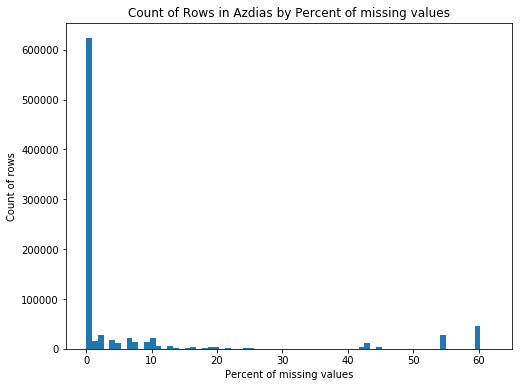

In [38]:
# Histogram of distribution of percentage of missing values for each row
plt.figure(figsize=(8,6))
plt.hist(azdias_clean.isnull().mean(axis=1)*100, bins=70);
plt.title("Count of Rows in Azdias by Percent of missing values")
plt.xlabel("Percent of missing values")
plt.ylabel("Count of rows");

In [39]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# It appears the large majority of rows have less than 30% of their data missing
# Meanwhile, there is a group of outlier rows with more than 30% of their data missing
# Hence we'll divide the data into two subsets based on a 30% missing data threshold. 

azdias_mt_30 = azdias_clean[azdias_clean.isnull().mean(axis=1)>=.3] # more than 30% data missing
azdias_lt_30 = azdias_clean[azdias_clean.isnull().mean(axis=1)<.3] # less than 30% data missing

In [40]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
# List of 10 columns with least number of missing values
mt_30_top = list(azdias_mt_30.isnull().mean(axis=0).sort_values().head(10).index)
mt_30_top

['ZABEOTYP',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM']

In [41]:
lt_30_top = list(azdias_lt_30.isnull().mean(axis=0).sort_values().head(10).index)
lt_30_top

['ZABEOTYP',
 'ANZ_TITEL',
 'ANZ_PERSONEN',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL']

In [42]:
top_col = []
for col in mt_30_top:
    if col in lt_30_top:
        top_col.append(col)
top_5 = top_col[0:5]
top_5        

['ZABEOTYP', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST']

5 shared columns for lowest (zero) missing values between 2 dataframes: ZABEOTYP, SEMIO_REL, SEMIO_MAT, SEMIO_VERT, SEMIO_LUST (also: SEMIO_ERL, SEMIO_KULT)

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [43]:
# As suggested, function to perform comparison between two sets of data for each column
def compare_dist(col_list, index):
    fig = plt.figure(figsize=(10,4))
    fig.suptitle(col_list[index])
    
    ax1 = plt.subplot(1,2,1)
    ax1.title.set_text('>=30% of data missing per row')
    sns.countplot(x=col_list[index], data=azdias_mt_30 )
    
    ax2 = plt.subplot(1,2,2)
    ax2.title.set_text('<30% of data missing per row')
    sns.countplot(x=col_list[index], data=azdias_lt_30 );
    
    plt.show();  

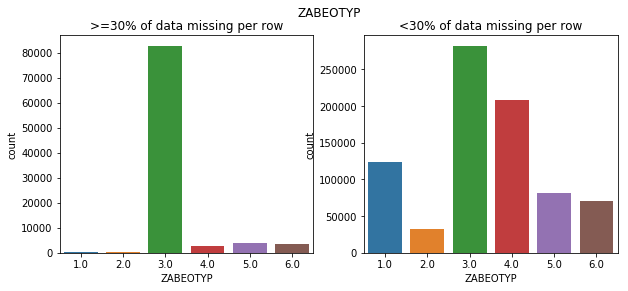

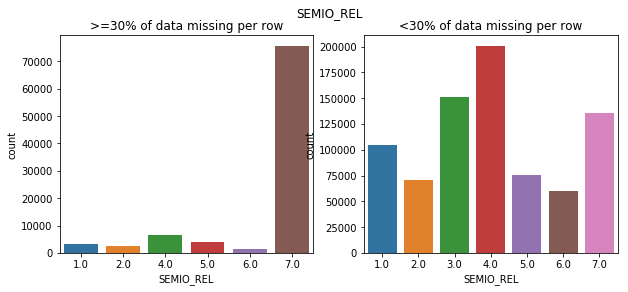

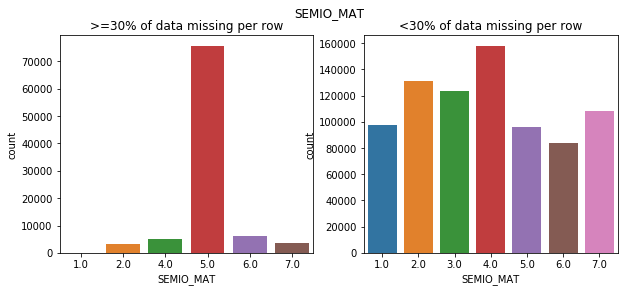

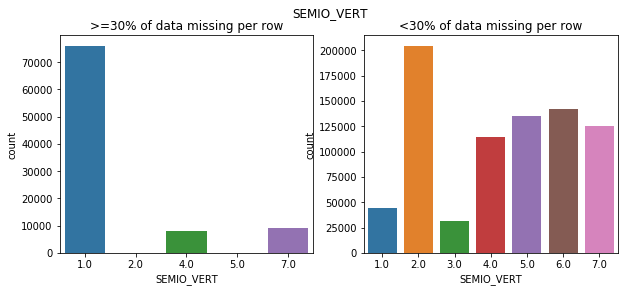

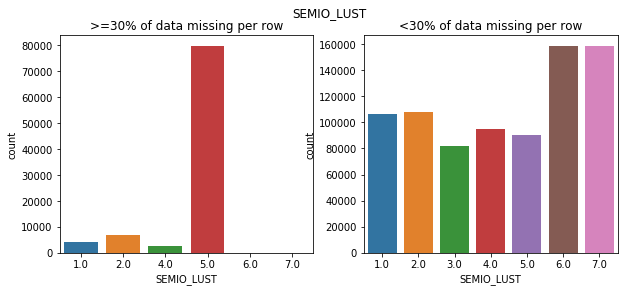

In [44]:
for i in range(len(top_5)):    
    compare_dist(top_5, i)

#### Discussion 1.1.3: Assess Missing Data in Each Row

As illustrated in the comparison bar charts above, the dataset with lots of missing values (>=30%) in each row have a rather different distribution of missing data per column compared to that found in the dataset with few missing values (< 30%). <br> 

As the distributions of non-missing features look different between the data with many missing values and the data with few or no missing values, it suggests some caution as far as dropping those points from the analysis -- we'll make a note on those data as special. 

Either way, as suggested, we'll continue our analysis for now using just the subset of the data with few or no missing values (i.e. < 30% of data missing in each row)

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [45]:
# How many features are there of each data type?
feat_clean.type.value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

In [46]:
feat_clean[feat_clean.type.isin(['ordinal','numeric'])]

,attribute,information_level,type,missing_or_unknown
0,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
3,FINANZ_MINIMALIST,person,ordinal,[-1]
4,FINANZ_SPARER,person,ordinal,[-1]
5,FINANZ_VORSORGER,person,ordinal,[-1]
6,FINANZ_ANLEGER,person,ordinal,[-1]
7,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
8,FINANZ_HAUSBAUER,person,ordinal,[-1]
12,HEALTH_TYP,person,ordinal,"[-1,0]"
21,RETOURTYP_BK_S,person,ordinal,[0]
22,SEMIO_SOZ,person,ordinal,"[-1,9]"


In [47]:
feat_clean[feat_clean.type.isin(['categorical', 'mixed'])]

,attribute,information_level,type,missing_or_unknown
1,ANREDE_KZ,person,categorical,"[-1,0]"
2,CJT_GESAMTTYP,person,categorical,[0]
9,FINANZTYP,person,categorical,[-1]
10,GFK_URLAUBERTYP,person,categorical,[]
11,GREEN_AVANTGARDE,person,categorical,[]
13,LP_LEBENSPHASE_FEIN,person,mixed,[0]
14,LP_LEBENSPHASE_GROB,person,mixed,[0]
15,LP_FAMILIE_FEIN,person,categorical,[0]
16,LP_FAMILIE_GROB,person,categorical,[0]
17,LP_STATUS_FEIN,person,categorical,[0]


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [48]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# first let's get a list of those variables which are categorical:
att_list = feat_clean[feat_clean.type.isin(['categorical'])]['attribute'].values
# we'll use this list to break down the number and type of categories:
cts = azdias_lt_30[att_list].nunique().sort_values()
cts

ANREDE_KZ            2
OST_WEST_KZ          2
VERS_TYP             2
SOHO_KZ              2
GREEN_AVANTGARDE     2
NATIONALITAET_KZ     3
SHOPPER_TYP          4
LP_STATUS_GROB       5
LP_FAMILIE_GROB      5
FINANZTYP            6
ZABEOTYP             6
CJT_GESAMTTYP        6
GEBAEUDETYP          7
CAMEO_DEUG_2015      9
LP_STATUS_FEIN      10
LP_FAMILIE_FEIN     11
GFK_URLAUBERTYP     12
CAMEO_DEU_2015      44
dtype: int64

In [49]:
# Let's see what kind of values are taken for those categorical variables with only 2 values
ct2 = cts[cts==2]
for column in ct2.index:
    print(azdias_lt_30[column].value_counts())

2.0    416018
1.0    381774
Name: ANREDE_KZ, dtype: int64
W    629292
O    168500
Name: OST_WEST_KZ, dtype: int64
2.0    394208
1.0    366977
Name: VERS_TYP, dtype: int64
0.0    791076
1.0      6716
Name: SOHO_KZ, dtype: int64
0.0    622601
1.0    175191
Name: GREEN_AVANTGARDE, dtype: int64


In [50]:
feat_info[feat_info['attribute'] == 'OST_WEST_KZ']

,attribute,information_level,type,missing_or_unknown
55,OST_WEST_KZ,building,categorical,[-1]


In [51]:
# Re-encode categorical variable(s) to be kept in the analysis.
# So it looks like OST_WEST_KZ is the one binary variable with non-numeric values that requires re-encoding as #s
# This feature corresponds to the "Building location via former East / West Germany (GDR / FRG)"
# Hence, re-encoding with binary numeric values of 1 for 'W' (West) and 0 for 'E' (East) will suffice
azdias_lt_30.loc[azdias_lt_30.OST_WEST_KZ =='W','OST_WEST_KZ'] = 1
azdias_lt_30.loc[azdias_lt_30.OST_WEST_KZ =='O','OST_WEST_KZ'] = 0
# Test code works
azdias_lt_30.OST_WEST_KZ.unique()

array([1, 0])

In [52]:
# Let's now review multi-level categoricals (three or more values):
ct_multi = list(cts[cts!=2].index)
ct_multi

['NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'LP_STATUS_GROB',
 'LP_FAMILIE_GROB',
 'FINANZTYP',
 'ZABEOTYP',
 'CJT_GESAMTTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'LP_STATUS_FEIN',
 'LP_FAMILIE_FEIN',
 'GFK_URLAUBERTYP',
 'CAMEO_DEU_2015']

After checking the dictionary, I decided to drop the multi-level (>2) categories for several reasons:
1. For simplicity purposes and to prevent an explosion of dimensions beyond the large list of dimensions we already have as the alternative of re-encoding would mean each value would translate into multiple dummy variables
2. Recognition that many of these features are duplicative of other ordinal/numeric/mixed categories (especially finance '..FINANZ...' and family situation '..FAMILIE..' related ones).  <br>
Furthermore, the direction of scale for the values of these categorical features is often not consistent with their similar oridinal counterparts (e.g. LP_STATUS_GROB and LP_STATUS_FEIN represent top earners w/ higher values and low income earners with lower values) whereas other features like HH_EINKOMMEN_SCORE represents the highest income individuals with the lowest values (scores).  Keeping these somewhat duplicative features would require correcting for these reverse scales for consistency and easier interpretation/analysis of our results later on.
3. Recognition that some of these features appear subjective and/or may not lend much value to the main question of interest (e.g. SHOPPER_TYP = shopper type)
4. Recognition that

In [53]:
# Here, I'll drop the multi-level features
for feature in ct_multi:
    azdias_lt_30=azdias_lt_30.drop(feature, axis=1)
azdias_lt_30.info()    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797792 entries, 1 to 891220
Data columns (total 66 columns):
ALTERSKATEGORIE_GROB     794995 non-null float64
ANREDE_KZ                797792 non-null float64
FINANZ_MINIMALIST        797792 non-null float64
FINANZ_SPARER            797792 non-null float64
FINANZ_VORSORGER         797792 non-null float64
FINANZ_ANLEGER           797792 non-null float64
FINANZ_UNAUFFAELLIGER    797792 non-null float64
FINANZ_HAUSBAUER         797792 non-null float64
GREEN_AVANTGARDE         797792 non-null float64
HEALTH_TYP               761185 non-null float64
LP_LEBENSPHASE_FEIN      747815 non-null float64
LP_LEBENSPHASE_GROB      750689 non-null float64
PRAEGENDE_JUGENDJAHRE    769148 non-null float64
RETOURTYP_BK_S           793126 non-null float64
SEMIO_SOZ                797792 non-null float64
SEMIO_FAM                797792 non-null float64
SEMIO_REL                797792 non-null float64
SEMIO_MAT                797792 non-null float64
SEMIO_V

#### Discussion 1.2.1: Re-Encode Categorical Features


For OST_WEST_KZ, I decided to re-encode the variable with binary numeric values of 1 for 'W' (West) and 0 for 'E' (East).

I decided to drop the multi-level (>2) categories for several reasons:
1. For simplicity purposes and to prevent an explosion of dimensions beyond the large list of dimensions we already have as the alternative of re-encoding would mean each value would translate into multiple dummy variables
2. Recognition that many of these features are duplicative of other ordinal/numeric/mixed categories (especially finance '..FINANZ...' and family situation '..FAMILIE..' related ones) 
3. Recognition that some of these features appear subjective and/or may not lend much value to the main question of interest (e.g. SHOPPER_TYP = shopper type)

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [54]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# Prior re-encoding of OST_WEST_KZ already captures East vs West, so we don't need to retain that info for this feature

# As suggested, we'll separate the 2 contained dimensions into 2 new variables (columns):
# - generation by decade
# - movement (mainstream vs. avantgarde)
azdias_lt_30['GENERATION'] = azdias_lt_30['PRAEGENDE_JUGENDJAHRE']
azdias_lt_30['MOVEMENT'] = azdias_lt_30['PRAEGENDE_JUGENDJAHRE']

# Now, we'll engineer these new variables as per specific dimensions via dictionary for replacement
# Generation Dictionary: 1 = 40s, 2 = 50s, 3 = 60s, 4 = 70s, 5 = 80s, 6 = 90s
gen_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
# Movement Dictionary: 1 = Mainstream, 0 = Avantgarde
mov_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
    
# Now we use those dictionaries for replacement
azdias_lt_30.GENERATION.replace(gen_dict, inplace=True)
azdias_lt_30.MOVEMENT.replace(mov_dict, inplace=True)

# Finally, we can drop the original column
azdias_lt_30.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

In [55]:
# Quick test
azdias_lt_30.GENERATION.unique()

array([  6.,   4.,   2.,   5.,   3.,  nan,   1.])

In [56]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# As suggested, we'll separated the 2 contained dimensions
# - WEALTH
# - LIFE_STAGE
azdias_lt_30['WEALTH'] = azdias_lt_30['CAMEO_INTL_2015']
azdias_lt_30['LIFE_STAGE'] = azdias_lt_30['CAMEO_INTL_2015']

# We'll break up the 2-digit codes by their 'tens' and 'ones'-place digits into 2 new ordinal variables:
# We'll create dictionaries to facilitate this break up
# wealth dictionary: 1=Wealthy, 2=Prosperous, 3=Comfortable, 4=Affluent, 5=Poorer
wealth_dict = {11:1, 12:1, 13:1, 14:1, 15:1, 21:2, 22:2, 23:2, 24:2, 25:2, 31:3, 32:3, 33:3, 34:3, 35:3,
              41:4, 42:4, 43:4, 44:4, 45:4, 51:5, 52:5, 53:5, 54:5, 55:5}

#life_dict = {11:1, 21:1, 31:1, 41:1, 51:1, 12:2, 22:2, 32:2, 42:2, 52:2, 13:3, 23:3, 33:3, 43:3, 53:3,
#            14:4, 24:4, 34:4, 44:4, 54:4, 15:5, 25:5, 35:5, 45:5, 55:5}

# life_stage dictionary: 5=pre-family & singles, 4=young couples w/ children, 3=familes w/ school age children, 
# 2=older families & mature couples, 1=elders in retirement # -1=unknown, xx=unknown
# Note to keep consistent with DECADE, the smaller numbers represent older people and higher numbers are younger
life_dict = {11:5, 21:5, 31:5, 41:5, 51:5, 12:4, 22:4, 32:4, 42:4, 52:4, 13:3, 23:3, 33:3, 43:3, 53:3,
            14:2, 24:2, 34:2, 44:2, 54:2, 15:1, 25:1, 35:1, 45:1, 55:1}
# Now we use those dictionary for replacement
azdias_lt_30.WEALTH.replace(wealth_dict, inplace=True)
azdias_lt_30.LIFE_STAGE.replace(life_dict, inplace=True)

# Finally, we can drop the original column
azdias_lt_30.drop('CAMEO_INTL_2015', axis=1, inplace=True)

In [57]:
# quick test
azdias_lt_30.WEALTH.unique()

array([  5.,   2.,   1.,   4.,   3.,  nan])

In [58]:
# Let's take a look at the other mixed type features
mixed_list = list(feat_clean[feat_clean.type.isin(['mixed'])].attribute.values)
mixed_list

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [59]:
# so we have the following other mixed type variables: 
# - LP_LEBENSPHASE_FEIN
# - LP_LEBENSPHASE_GROB
# - WOHNLAGE
# - PLZ8_BAUMAX

# LP_LEBENSPHASE_FEIN: life stage, fine scale
# Analysis: this variable captures the same life stage and income information as the earlier 
# created columns 'WEALTH' and 'LIFE_STAGE'.  In addition the direction of scale appears inconsistent w/ other features
# Hence we can drop it.

# LP_LEBENSPHASE_GROB: Life stage, rough scale
# Analysis: same conclusion as LP_LEBENSPHASE_FEIN - can drop this column.

# WOHNLAGE: Neighborhood quality
# Analysis: this variable appears to have similar information as the existing ordinal column "REGIOTYP" 
# (Neigborhood typology), so it can be dropped.

# PLZ8_BAUMAX: Most common building type within the PLZ8 region
# Analysis: This variable appears to have similar information as these 2 other columns and can be dropped:
# ANZ_HAUSHALTE_AKTIV: of households in the building
# GEBAEUDETYP: type of building (residential vs commercial)

In [60]:
azdias_lt_30.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX'], axis=1, inplace=True)

In [61]:
# sanity check
azdias_lt_30.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797792 entries, 1 to 891220
Data columns (total 64 columns):
ALTERSKATEGORIE_GROB     794995 non-null float64
ANREDE_KZ                797792 non-null float64
FINANZ_MINIMALIST        797792 non-null float64
FINANZ_SPARER            797792 non-null float64
FINANZ_VORSORGER         797792 non-null float64
FINANZ_ANLEGER           797792 non-null float64
FINANZ_UNAUFFAELLIGER    797792 non-null float64
FINANZ_HAUSBAUER         797792 non-null float64
GREEN_AVANTGARDE         797792 non-null float64
HEALTH_TYP               761185 non-null float64
RETOURTYP_BK_S           793126 non-null float64
SEMIO_SOZ                797792 non-null float64
SEMIO_FAM                797792 non-null float64
SEMIO_REL                797792 non-null float64
SEMIO_MAT                797792 non-null float64
SEMIO_VERT               797792 non-null float64
SEMIO_LUST               797792 non-null float64
SEMIO_ERL                797792 non-null float64
SEMIO_K

In [62]:
azdias_lt_30.columns.sort_values().values.tolist()

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'ARBEIT',
 'BALLRAUM',
 'EWDICHTE',
 'FINANZ_ANLEGER',
 'FINANZ_HAUSBAUER',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_VORSORGER',
 'GEBAEUDETYP_RASTER',
 'GENERATION',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'HH_EINKOMMEN_SCORE',
 'INNENSTADT',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'KBA13_ANZAHL_PKW',
 'KKK',
 'KONSUMNAEHE',
 'LIFE_STAGE',
 'MIN_GEBAEUDEJAHR',
 'MOBI_REGIO',
 'MOVEMENT',
 'ONLINE_AFFINITAET',
 'ORTSGR_KLS9',
 'OST_WEST_KZ',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_GBZ',
 'PLZ8_HHZ',
 'REGIOTYP',
 'RELAT_AB',
 'RETOURTYP_BK_S',
 'SEMIO_DOM',
 'SEMIO_ERL',
 'SEMIO_FAM',
 'SEMIO_KAEM',
 'SEMIO_KRIT',
 'SEMIO_KULT',
 'SEMIO_LUST',
 'SEMIO_MAT',
 'SEMIO_PFLICHT',
 'SEMIO_RAT',
 'SEMIO_REL',
 'SEMIO_SOZ',
 'SEMIO_TRADV',
 'SEMIO_VERT',
 'SOHO_KZ',
 'VERS_TYP',
 'WEALTH'

#### Discussion 1.2.2: Engineer Mixed-Type Features

As described in the inline comments above, the following 2 mixed-type features were re-engineered: 
- PRAEGENDE_JUGENDJAHRE
- CAMEO_INTL_2015 <br>

Given the above 2 variables each captured several dimensions, they were  replaced with multiple variables to capture
each dimension as follows:

PRAEGENDE_JUGENDJAHRE was divided into 2 new columns (variables) as follows: 
1. GENERATION (aka decade from 40s to 90s)
2. MOVEMENT (Mainstream vs Avantgarde).  <br>

In addition the 3rd dimension of East vs West was dropped as it lacked some details and was captured elsewhere already

CAMEO_INTL_2015 was divided into 2 new columns (variables) as follows:
1. WEALTH (from wealthiest to poorest - the lower the number the wealthier the individual)
2. LIFE_STAGE (from pre-family & singles to elders in retirement - the higher the number the older the individual)

In regards to the other mixed-type features:
 - LP_LEBENSPHASE_FEIN
 - LP_LEBENSPHASE_GROB
 - WOHNLAGE
 - PLZ8_BAUMAX <br>
 
These features were all dropped as the information they captured was similar or duplicative of other features that were already being retained.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [63]:
# confirm numeric, interval and ordinal type columns are retained
# first get list of such features
num_features = list(feat_clean[feat_clean.type.isin(['numeric', 'interval', 'ordinal'])].attribute.values)
#retained_features = azdias_lt_30.columns.values
# second confirm such features are found in latest cleaned dataset excluding those we've removed
for column in num_features:
    if column in azdias_lt_30.columns.values:
        pass
    else:
        print(column, 'not retained as expected')

As per the above, it looks like all numeric, interval and ordinal types columns were retained as intended

In [64]:
# Let's now confirm remaining cateogrical features are only binary

# first let's get a list of those variables which are categorical:
category_list = list(feat_clean[feat_clean.type.isin(['categorical'])]['attribute'].values)
# we'll use this list to break down which of these categorical variables are retained
retained_list = azdias_lt_30.columns[azdias_lt_30.columns.isin(category_list)].values
# Now let's confirm these remaining categorical variables are binary (have only 2 numerically encoded values)
for column in retained_list:
    print(azdias_lt_30[column].value_counts())

2.0    416018
1.0    381774
Name: ANREDE_KZ, dtype: int64
0.0    622601
1.0    175191
Name: GREEN_AVANTGARDE, dtype: int64
0.0    791076
1.0      6716
Name: SOHO_KZ, dtype: int64
2.0    394208
1.0    366977
Name: VERS_TYP, dtype: int64
1    629292
0    168500
Name: OST_WEST_KZ, dtype: int64


As per the above, we've confirmed the remaining categorical features are only binary (have only 2 numerically encoded values)

In [65]:
# Next we'll confirm mixed_columns have been re-engineered and dropped as expected (i.e. no mixed type categories)
azdias_lt_30.columns.isin(mixed_list).any()

False

As per the above, we've confirmed mixed columns have been re-engineered and dropped as expected (i.e. no mixed type categories)

In [66]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Let's look at direction of scale for remaining variables
# To ensure simplicity for analysis, we'll try to make this consistent

In [67]:
# "ALTERSKATEGORIE_GROB: Estimated age based on given name analysis" should be reverse direction of scale
# This makes the feature consistent with earlier engineered features of GENERATION and LIFE_STAGE
# smaller values represent older people and larger values corresponds to younger people
azdias_lt_30.ALTERSKATEGORIE_GROB.value_counts()

3.0    310305
4.0    223216
2.0    137078
1.0    124396
Name: ALTERSKATEGORIE_GROB, dtype: int64

In [68]:
azdias_lt_30.ALTERSKATEGORIE_GROB = azdias_lt_30.ALTERSKATEGORIE_GROB.max() + 1 - azdias_lt_30.ALTERSKATEGORIE_GROB
azdias_lt_30.ALTERSKATEGORIE_GROB.value_counts()

2.0    310305
1.0    223216
3.0    137078
4.0    124396
Name: ALTERSKATEGORIE_GROB, dtype: int64

New data dictionary value for ALTERSKATEGORIE_GROB is as follows:
-  4: < 30 years old
-  3: 30 - 45 years old
-  2: 46 - 60 years old
-  1: > 60 years old

In [69]:
# "ANZ_TITEL: Number of professional academic title holders in household" should perhaps be reverse direction of scale
# This makes the feature consistent with other features like HH_EINKOMMEN_SCORE where
# smaller values represent more academic titles (similar to income) and larger values corresponds to less titles

In [70]:
azdias_lt_30.ANZ_TITEL.value_counts()

0.0    794692
1.0      2894
2.0       198
3.0         5
4.0         2
6.0         1
Name: ANZ_TITEL, dtype: int64

In [71]:
azdias_lt_30.ANZ_TITEL = (azdias_lt_30.ANZ_TITEL.max() + 1) - azdias_lt_30.ANZ_TITEL
azdias_lt_30.ANZ_TITEL.value_counts()

7.0    794692
6.0      2894
5.0       198
4.0         5
3.0         2
1.0         1
Name: ANZ_TITEL, dtype: int64

New data dictionary value for ANZ_TITEL is as follows:
- 7: 0 academic title holders in household
- 6: 1 academic title holders in household
- 5: 2 academic title holders in household
- 4: 3 academic title holders in household
- 3: 4 academic title holders in household
- 2: 5 academic title holders in household
- 1: 6 academic title holders in household

In [72]:
# "ANZ_HH_TITEL: Number of professional academic title holders in building"
# This feature should be changed to a density score equal to the
# average professional academic title holders per household in building
# to achieve this we'll divide by ANZ_HAUSHALTE_AKTIV (# of households in the building)
# if 

In [73]:
azdias_lt_30.ANZ_HH_TITEL.value_counts()

0.0     770026
1.0      20152
2.0       2458
3.0        585
4.0        232
5.0        117
6.0        106
8.0         68
7.0         65
9.0         34
13.0        29
12.0        22
11.0        22
14.0        16
10.0        16
17.0        13
20.0         9
15.0         7
18.0         6
16.0         3
23.0         3
Name: ANZ_HH_TITEL, dtype: int64

In [74]:
azdias_lt_30[azdias_lt_30.ANZ_HAUSHALTE_AKTIV.isnull()].ANZ_HH_TITEL.unique()

array([  0.,  nan,   1.])

In [75]:
azdias_lt_30[azdias_lt_30.ANZ_HAUSHALTE_AKTIV.isnull()].ANZ_HH_TITEL.value_counts()

0.0    2590
1.0      13
Name: ANZ_HH_TITEL, dtype: int64

In [76]:
'''
# Create new column for capturing new value for ANZ_HH_TITEL
azdias_lt_30['ANZ_HH_TITEL_NEW'] = azdias_lt_30['ANZ_HH_TITEL']
azdias_lt_30['ANZ_HH_TITEL_NEW'] = azdias_lt_30['ANZ_HH_TITEL_NEW']/azdias_lt_30['ANZ_HAUSHALTE_AKTIV'] 
'''

"\n# Create new column for capturing new value for ANZ_HH_TITEL\nazdias_lt_30['ANZ_HH_TITEL_NEW'] = azdias_lt_30['ANZ_HH_TITEL']\nazdias_lt_30['ANZ_HH_TITEL_NEW'] = azdias_lt_30['ANZ_HH_TITEL_NEW']/azdias_lt_30['ANZ_HAUSHALTE_AKTIV'] \n"

In [77]:
'''
# when ANZ_HAUSHALTE_AKTIV is null, ANZ_HH_TITEL will be either null or 0 (in the case ANZ_HH_TITEL = 0 already)
azdias_lt_30.loc[azdias_lt_30.ANZ_HH_TITEL == 0, 'ANZ_HH_TITEL_NEW'] = 0
'''

"\n# when ANZ_HAUSHALTE_AKTIV is null, ANZ_HH_TITEL will be either null or 0 (in the case ANZ_HH_TITEL = 0 already)\nazdias_lt_30.loc[azdias_lt_30.ANZ_HH_TITEL == 0, 'ANZ_HH_TITEL_NEW'] = 0\n"

In [78]:
'''
# replace old column with new column
azdias_lt_30.drop('ANZ_HH_TITEL', axis=1, inplace=True)
azdias_lt_30.rename(columns={'ANZ_HH_TITEL_NEW':'ANZ_HH_TITEL'}, inplace=True)
azdias_lt_30.ANZ_HH_TITEL.value_counts()
'''

"\n# replace old column with new column\nazdias_lt_30.drop('ANZ_HH_TITEL', axis=1, inplace=True)\nazdias_lt_30.rename(columns={'ANZ_HH_TITEL_NEW':'ANZ_HH_TITEL'}, inplace=True)\nazdias_lt_30.ANZ_HH_TITEL.value_counts()\n"

New data dictionary value for ANZ_HH_TITEL is as follows: 
ANZ_HH_TITEL: Number of professional academic title holders per household in building

In [79]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# No other additional tasks needed

In [80]:
azdias_lt_30.shape

(797792, 64)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [81]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # first create a copy of the dataset
    df_clean = df.copy()
    # convert missing value codes into NaNs, ...
 
    # Loop through pairs of attributes and corresponding missing value strings in feat_info 
    # convert resulting strings into lists
    for attribute, missing_val in zip(feat_info.attribute, feat_info.missing_or_unknown):
        # for each attribute, instantiate a list to hold converted strings of missing values
        missing_list = []
        # Loop through string and add each item to list
        for i in missing_val[1:-1].split(','):
            missing_list.append(i)
            # now for each matching attribute in the dataset 
            # if it's row value is found in the list of missing values from feat_info, convert to NAN
            df_clean.loc[df['{}'.format(attribute)].isin(missing_list), '{}'.format(attribute)]=np.NaN
            
    # Convert column types into a numeric datatype
    df_clean.CAMEO_DEUG_2015 = df_clean.CAMEO_DEUG_2015.astype('Float64')
    df_clean.CAMEO_INTL_2015 = df_clean.CAMEO_INTL_2015.astype('Float64')             

    # remove selected columns and rows, ...
    # As we're comparing the customer dataset against the general population dataset,  
    # we don't need the columns we dropped from the general population dataset
    # Hence, we'll remove the following 6 columns which had >= 35% of data missing in the general population dataset
    col_miss_35 = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR',
           'ALTER_HH']
    df_clean.drop(col_miss_35, axis=1, inplace=True)
    # similarly, we don't need the rows with more than 30% of their data missing
    df_lt_30 = df_clean[df_clean.isnull().mean(axis=1)<.3] 

    # select, re-encode, and engineer column values.
    
    # We'll remove multi-level categorical attributes as follows:
    # recall ct_multi is a list capturing mutli-level categorical attributes
    df_lt_30.drop(ct_multi, axis=1, inplace=True)
    
    # We'll re-encode OST_WEST_KZ with binary numeric values of 1 for 'W' (West) and 0 for 'E' (East) will suffice
    df_lt_30.loc[df_lt_30.OST_WEST_KZ =='W','OST_WEST_KZ'] = 1
    df_lt_30.loc[df_lt_30.OST_WEST_KZ =='O','OST_WEST_KZ'] = 0    

    # Re-engineer the 2 variables that capture multiple dimensions into new variables that capture a single dimension
    # First is PRAEGENDE_JUGENDJAHRE
    df_lt_30['GENERATION'] = df_lt_30['PRAEGENDE_JUGENDJAHRE']
    df_lt_30['MOVEMENT'] = df_lt_30['PRAEGENDE_JUGENDJAHRE'] 
    # We'll re-use our earlier dictionaries for replacement
    df_lt_30.GENERATION.replace(gen_dict, inplace=True)
    df_lt_30.MOVEMENT.replace(mov_dict, inplace=True)
    # Then, we can drop the original column
    df_lt_30.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    # Repeat for CAMEO_INTL_2015
    df_lt_30['WEALTH'] = df_lt_30['CAMEO_INTL_2015']
    df_lt_30['LIFE_STAGE'] = df_lt_30['CAMEO_INTL_2015']    
    # We'll re-use our earlier dictionary for replacement
    df_lt_30.WEALTH.replace(wealth_dict, inplace=True)
    df_lt_30.LIFE_STAGE.replace(life_dict, inplace=True)    
    # Then, we can drop the original column
    df_lt_30.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    # Lastlly, we'll drop the other mixed-type columns
    df_lt_30.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX'], axis=1, inplace=True)    
    
    # Reverse direction of scale for ALTERSKATEGORIE_GROB and ANZ_TITEL
    df_lt_30.ALTERSKATEGORIE_GROB = df_lt_30.ALTERSKATEGORIE_GROB.max() + 1 - df_lt_30.ALTERSKATEGORIE_GROB
    df_lt_30.ANZ_TITEL = df_lt_30.ANZ_TITEL.max() + 1 - df_lt_30.ANZ_TITEL
    
    # Return the cleaned dataframe.
    return df_lt_30

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [82]:
# check columns with null values before imputing
azdias_nulls = azdias_lt_30.columns[azdias_lt_30.isnull().any()]
azdias_nulls

Index(['ALTERSKATEGORIE_GROB', 'HEALTH_TYP', 'RETOURTYP_BK_S', 'VERS_TYP',
       'W_KEIT_KIND_HH', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ',
       'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK',
       'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW',
       'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ',
       'PLZ8_GBZ', 'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB', 'GENERATION',
       'MOVEMENT', 'WEALTH', 'LIFE_STAGE'],
      dtype='object')

In [83]:
# Let's see the distribution of these columns with null values
# normal distribution: mean = median
# skewed right distribution: mean > median
# skewed left distribution: mean < median
azdias_lt_30[azdias_nulls].describe().loc[['mean', '50%'],:]

,ALTERSKATEGORIE_GROB,HEALTH_TYP,RETOURTYP_BK_S,VERS_TYP,W_KEIT_KIND_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,KBA05_ANTG1,KBA05_ANTG2,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,GENERATION,MOVEMENT,WEALTH,LIFE_STAGE
mean,2.204598,2.199086,3.443018,1.517887,4.161903,8.356087,0.040649,3.023049,1.494277,1.265584,...,0.699167,3.61282,3.381084,3.166781,5.293518,3.071104,4.33196,0.772227,3.262261,3.126983
50%,2.000000,2.000000,4.000000,2.000000,4.000000,4.000000,0.000000,3.000000,1.000000,1.000000,...,1.000000,4.00000,3.000000,3.000000,5.000000,3.000000,4.00000,1.000000,4.000000,3.000000


### Discussion: Imputing missing values
I can't use the 'mean' as my strategy for imputation replacement of missing values because the columns contain discrete whole number integers (e.g. some columns contain ordinal values) rather than floats that the mean would provide.  As far as other possibilities, I've confirmed the distributions of values are not normal or nearly normal for a lot of columns with missing values (nor are the distributions consistently skewed left or right).  Hence, I've decided to use the 'most_frequent' strategy rather than the mean or median for imputation replacement of missing values.

In [84]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
# we'll replace remaining missing values with the 'most frequent' value for each column
imp = Imputer(missing_values=np.nan, strategy='most_frequent')
azdias_impute = pd.DataFrame(imp.fit_transform(azdias_lt_30))

In [85]:
azdias_impute.columns = azdias_lt_30.columns
azdias_impute.index = azdias_lt_30.index

In [86]:
# confirm no columns with null values after imputing
azdias_impute.isnull().any().sum()

0

- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [87]:
# As suggested, I'll applying Standard Scaler function for scaling each feature to mean 0 and std 1
scaler = StandardScaler()
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_impute))
azdias_scaled.columns = azdias_impute.columns
azdias_scaled.index = azdias_impute.index

In [88]:
# quick sanity check
azdias_scaled.describe().round(2)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,GENERATION,MOVEMENT,WEALTH,LIFE_STAGE
count,797792.00,797792.00,797792.00,797792.00,797792.00,797792.00,797792.00,797792.00,797792.00,797792.00,...,797792.00,797792.00,797792.00,797792.00,797792.00,797792.00,797792.00,797792.00,797792.00,797792.00
mean,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,...,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.18,-1.04,-1.49,-1.16,-1.77,-1.25,-1.18,-1.50,-0.53,-1.63,...,-0.94,-2.69,-2.16,-2.17,-1.87,-1.53,-2.32,-1.89,-1.55,-1.44
25%,-1.18,-1.04,-0.77,-1.16,-1.04,-1.25,-1.18,-0.79,-0.53,-0.31,...,-0.94,-0.62,-0.34,-0.17,-0.56,-0.79,-0.95,0.53,-0.87,-0.77
50%,-0.20,0.96,-0.04,0.19,0.41,0.11,-0.47,-0.08,-0.53,-0.31,...,0.44,-0.62,-0.34,-0.17,-0.13,-0.05,0.42,0.53,0.49,-0.09
75%,0.78,0.96,0.68,0.86,1.14,0.79,0.96,0.63,-0.53,1.01,...,0.44,0.42,0.57,0.83,0.74,0.68,1.10,0.53,1.18,1.25
max,1.77,0.96,1.41,1.54,1.14,1.47,1.67,1.34,1.89,1.01,...,1.82,1.46,1.49,1.83,1.61,1.42,1.10,0.53,1.18,1.25


### Discussion 2.1: Apply Feature Scaling¶

As described above, I chose to use the 'most_frequent' value as my imputation replacement strategy for remaining null values.  This decision was in consideration of the need for whole integer values rather than floats (thus excluding 'mean' strategy), and a non-normal and inconsistent distribution of values per column (thus muddying the choice of 'median' strategy). <br>
In terms of scaling, I used the Standard Scalar as suggested to scale each feature to a mean 0 and standard deviation 1 as confirmed above.  This helps prevent certain features with overall large values from having outsized impacts on our subsequent clustering algorithm and vice versa.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [89]:
# Apply PCA to the data.
pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled)

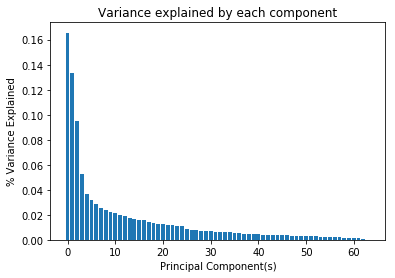

In [90]:
# Investigate the variance accounted for by each principal component.
component_ct = len(pca.explained_variance_ratio_)
x_labels = np.arange(component_ct)
plt.bar(x_labels, pca.explained_variance_ratio_)
plt.title("Variance explained by each component")
plt.xlabel("Principal Component(s)")
plt.ylabel("% Variance Explained")
plt.show();

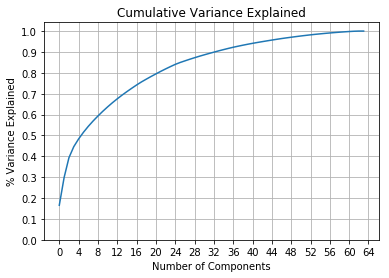

In [91]:
# Check out the cumulative variance accounted for the principal components

# calculate cumulative sum of principal components
pc_cum_sum = np.cumsum(pca.explained_variance_ratio_)
# plot the cumulative variance
plt.plot(x_labels, pc_cum_sum);
plt.title("Cumulative Variance Explained")
plt.xlabel("Number of Components")
plt.ylabel("% Variance Explained")
plt.xticks(np.arange(0,len(pca.explained_variance_ratio_)+4,4))
plt.yticks(np.arange(0,1.1,0.1))
plt.grid()
plt.show();

In [92]:
# Re-apply PCA to the data while selecting for number of components to retain.
# As per the chart above, the first 32 principal components capture 90% of the variance 
# so with effectively half the number of components, we can still capture 90% of the variance
pca_32 = PCA(n_components=32)
azdias_pca = pca_32.fit_transform(azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

As per the charts and analysis above, we discovered that we can capture 90% of the variance with just 32 principal components (transformed features).  If we wanted to be more aggressive, we could just use 20 principal components and still capture 80% of the variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [93]:
# Test code for how each component weight vector looks like
(pca_32.components_[0])

array([ 0.12556031,  0.00751762, -0.22306846,  0.15305189, -0.12012799,
        0.07504969,  0.08103844,  0.15955552, -0.11021741,  0.04118946,
       -0.02169524,  0.04329638,  0.08098668,  0.11854672,  0.0824127 ,
       -0.040606  , -0.07686695, -0.08014397,  0.07549774,  0.09953307,
        0.0038001 ,  0.02376682,  0.03940146,  0.12111911,  0.09367537,
       -0.00198809,  0.03258604, -0.07808399,  0.00421589,  0.20223158,
        0.03637233, -0.0612505 ,  0.1360604 ,  0.03385519, -0.1674018 ,
       -0.04321437, -0.05366689, -0.21446241,  0.01374002,  0.13673703,
        0.15399816, -0.21605988, -0.12733943,  0.19465787, -0.16463748,
       -0.11719427,  0.03958529, -0.22485931, -0.0413069 ,  0.06033484,
       -0.07399508, -0.22566333,  0.15368431,  0.22534721,  0.21691127,
        0.04224945, -0.16638456,  0.1425739 ,  0.19676956,  0.13495622,
        0.11220442,  0.11021741,  0.20465551,  0.12516634])

In [94]:
# test code for creating a mapping of weights to corresponding features for the first principle component
pd.DataFrame(pca_32.components_[0], index=azdias_scaled.columns, columns=['WEIGHT']).\
sort_values(by='WEIGHT', ascending=False).head()

,WEIGHT
PLZ8_ANTG3,0.225347
PLZ8_ANTG4,0.216911
WEALTH,0.204656
HH_EINKOMMEN_SCORE,0.202232
ORTSGR_KLS9,0.196770


In [95]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def map_weights(pca, pc_num):
    df = pd.DataFrame(pca.components_[pc_num-1], index=azdias_scaled.columns, columns=['WEIGHTS_PC'+str(pc_num)])
    return df.sort_values(by='WEIGHTS_PC'+str(pc_num), ascending=False)
print(map_weights(pca_32,1))

                       WEIGHTS_PC1
PLZ8_ANTG3                0.225347
PLZ8_ANTG4                0.216911
WEALTH                    0.204656
HH_EINKOMMEN_SCORE        0.202232
ORTSGR_KLS9               0.196770
EWDICHTE                  0.194658
FINANZ_HAUSBAUER          0.159556
KBA05_ANTG4               0.153998
PLZ8_ANTG2                0.153684
FINANZ_SPARER             0.153052
ARBEIT                    0.142574
KBA05_ANTG3               0.136737
ANZ_HAUSHALTE_AKTIV       0.136060
RELAT_AB                  0.134956
ALTERSKATEGORIE_GROB      0.125560
LIFE_STAGE                0.125166
SEMIO_PFLICHT             0.121119
SEMIO_REL                 0.118547
GENERATION                0.112204
MOVEMENT                  0.110217
SEMIO_RAT                 0.099533
SEMIO_TRADV               0.093675
SEMIO_MAT                 0.082413
FINANZ_UNAUFFAELLIGER     0.081038
SEMIO_FAM                 0.080987
SEMIO_KULT                0.075498
FINANZ_ANLEGER            0.075050
REGIOTYP            

In [96]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(map_weights(pca_32, 2))

                       WEIGHTS_PC2
SEMIO_ERL                 0.229927
FINANZ_VORSORGER          0.229257
SEMIO_LUST                0.180128
RETOURTYP_BK_S            0.161924
FINANZ_HAUSBAUER          0.121770
SEMIO_KRIT                0.117889
SEMIO_KAEM                0.116429
W_KEIT_KIND_HH            0.114759
PLZ8_ANTG3                0.098371
EWDICHTE                  0.097856
ORTSGR_KLS9               0.096540
PLZ8_ANTG4                0.096177
ANREDE_KZ                 0.093154
WEALTH                    0.079200
KBA05_ANTG4               0.075188
SEMIO_DOM                 0.074489
ARBEIT                    0.071784
RELAT_AB                  0.069267
PLZ8_ANTG2                0.068147
ANZ_HAUSHALTE_AKTIV       0.066438
HH_EINKOMMEN_SCORE        0.061884
FINANZ_MINIMALIST         0.059415
WOHNDAUER_2008            0.058436
KBA05_ANTG3               0.050524
VERS_TYP                  0.032153
ANZ_HH_TITEL              0.032067
MOVEMENT                  0.018358
PLZ8_HHZ            

In [97]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(map_weights(pca_32, 3))

                       WEIGHTS_PC3
SEMIO_VERT                0.344669
SEMIO_SOZ                 0.261920
SEMIO_FAM                 0.248862
SEMIO_KULT                0.233896
FINANZ_MINIMALIST         0.154512
RETOURTYP_BK_S            0.109043
FINANZ_VORSORGER          0.101732
W_KEIT_KIND_HH            0.085128
SEMIO_REL                 0.067723
SEMIO_LUST                0.064505
SEMIO_MAT                 0.055642
ORTSGR_KLS9               0.050266
EWDICHTE                  0.049483
PLZ8_ANTG4                0.049162
PLZ8_ANTG3                0.048406
GREEN_AVANTGARDE          0.047114
ARBEIT                    0.037336
RELAT_AB                  0.034351
PLZ8_ANTG2                0.032670
WOHNDAUER_2008            0.032619
WEALTH                    0.030184
KBA05_ANTG4               0.029973
ANZ_HAUSHALTE_AKTIV       0.026796
ANZ_HH_TITEL              0.013916
KBA05_ANTG3               0.011868
LIFE_STAGE                0.010042
PLZ8_HHZ                  0.005616
VERS_TYP            

In [98]:
print(map_weights(pca_32, 2).head(4))
print(map_weights(pca_32, 2).tail(4))

                  WEIGHTS_PC2
SEMIO_ERL            0.229927
FINANZ_VORSORGER     0.229257
SEMIO_LUST           0.180128
RETOURTYP_BK_S       0.161924
                      WEIGHTS_PC2
FINANZ_SPARER           -0.231681
GENERATION              -0.238576
SEMIO_REL               -0.253658
ALTERSKATEGORIE_GROB    -0.256295


In [99]:
print(map_weights(pca_32, 3).head(4))
print(map_weights(pca_32, 3).tail(4))

            WEIGHTS_PC3
SEMIO_VERT     0.344669
SEMIO_SOZ      0.261920
SEMIO_FAM      0.248862
SEMIO_KULT     0.233896
            WEIGHTS_PC3
SEMIO_KRIT    -0.275147
SEMIO_DOM     -0.313054
SEMIO_KAEM    -0.335060
ANREDE_KZ     -0.367352


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

#### First Principal Component: 
**Analysis:** As listed below, the features with the highest weights and positive correlations to one another tend to describe larger, denser households and communities whereas the featuers with the lowest weights tend to describe low density family houses and buildings.  In addition and of interesting note is that the 3rd highest weighted feature captures the wealth (higher scores mean lower wealth) and similarly the 4th highest score captures the income (higher score means lower income) <br>
From this information, we can infer that when the share of 10+ family homes increase we can also expect the share of 6-10+ family homes to increase as well.  Similarly, along with the size of the family houses, the wealth and income of individuals decreases while the size of the community also increases -- this might be expected as poorer individuals would live in denser buildings and communities (i.e. more families per home and people per community).  

On the other side,  when analyzing the negative weights we can expect more less crowded 1-2 family homes, movement and accompanying high financial interest typology to move in step in the opposite direction (e.g. people who can afford to live in/own less crowded homes tend to identify as having higher financial interest and tend to move less frequently etc.)

**Top 5 positive weights:** (higher to lower)
- PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region (none to high share) (0.225347)
- PLZ8_ANTG4: Number of 10+ family houses in the PLZ8 region (none to high share) (0.216911)
- WEALTH: top earners (low values) to low-income (high values) (0.204656)
- HH_EINKOMMEN_SCORE: Estimated household net income (highest to very low) (0.202232)
- ORTSGR_KLS9: Size of community (<=2000 to >700,000) (0.196770)

**Bottom 5 negative weights:**
- KBA05_ANTG1: Number of 1-2 family houses in the microcell (none to very high share) (-0.214462)
- KBA05_GBZ: Number of buildings in the microcell (1 to >= 23) (-0.216060)
- FINANZ_MINIMALIST: Financial typology, for low financial interest dimension (very high to very low) (-0.223068)
- MOBI_REGIO: Movement patterns (very high to no movement) (-0.224859)
- PLZ8_ANTG1: Number of 1-2 family houses in the PLZ8 region (none to very high share) (-0.225663)


#### Second Principal Component: 
**Analysis:** Note, for brevity purposes we'll only cover the top and bottom 4 weighted features for the second principal component.  For the second principal component, it is positively weighted towards individuals who have low affinity with personality typologies of 'event-oriented' and 'sensual-mindedness' as well as low identification of financial typology as having a 'be-prepared' mindset.  Also of interest for this use case (i.e. of mail order deliveries) was the 4th highest component of 'RETOURTYP_BK_S' which is the likelihood the individual will return an item (from crazy/heavy returner to minimal returner), suggesting that the less an individual identifies as event-oriented/sensual or having a 'be-prepared' financial mindset, the less likely the individual will return an item <br>
<br>
In contrast, the second principal component has the lowest negative weights for the typology of'religious personality', generation, age and financial typology for a 'money-saver' mindset.  Hence, we can interpret that these last 3 features tend to move together in an opposite direction relative to the second principal component and compared to the high positive weighted features.  Someone of a younger age would naturally belong to a younger generation, but we also find that younger people would identify less as 'money savers or religious' and would be crazy-shoppers/heavy returners  while older people would identify more as event-oriented/sensual or having a 'be-prepared' financial mindset as well as be less likely to return an item they purchased.

**Top 4 positive weights:** (higher to lower)
- SEMIO_ERL: Personality typology, for 'event-oriented' dimension (highest to lowest affinity) 0.229927
- FINANZ_VORSORGER: Financial typology for 'be prepared' dimension (very high to very low) 0.229257
- SEMIO_LUST: Personality typology, for 'sensual-minded' dimension (highest to lowest affinity) 0.180128
- RETOURTYP_BK_S: Return type (influenceable Crazy-Shopper/Heavy Returner to determined Minimal-Returner) 0.161924

**Bottom 4 negative weights:**

- FINANZ_SPARER: Financial typology, for 'money-saver' dimension (very high to very low) -0.231681
- GENERATION: Generation by decade (40s to 90s) -0.238576
- SEMIO_REL: Personality typology for 'religious' dimension (highest to lowest affinity) -0.253658
- ALTERSKATEGORIE_GROB: Estimated age based on given name analysis (>60 to <30 yrs old) -0.256295

#### Third Principal Component: 
**Analysis:** Note, for brevity purposes we'll only cover the top and bottom 3 weighted features for the third principal components.  For the third principal component, it is positively weighted towards the personality typology of people with low personality affinities of 'dreamful', 'socially-minded' and 'family-minded' dispositions.  Hence, people who identify as dreamful tend to also be socially and family-minded as well.  <br>
In contrast, the third principal component has the lowest negative weights for the personality typology of people who do not identify as 'dominant-minded' or have a 'combative-attitude' as well as who are male.  Hence, people who are dreamful/socially-minded/and family-oriented are less likely to identify as dominant/combative and male.

**Top 3 positive weights:** (higher to lower)
- SEMIO_VERT: Personality typology, for 'dreamful' dimension (highest to lowest affinity) 0.344669
- SEMIO_SOZ: Personality typology, for 'socially-minded' dimension (highest to lowest affinity) 0.261920
- SEMIO_FAM: Personality typology, for 'family-minded' dimension (highest to lowest affinity) 0.248862

**Bottom 3 negative weights:**
- SEMIO_DOM: Personality typology, for 'dominant-minded' dimension (highest to lowest affinity) -0.313054
- SEMIO_KAEM:Personality typology, for 'combative attitude' dimension (highest to lowest affinity) -0.335060
- ANREDE_KZ: Gender (male (1) /female (2) /unknown (0)) -0.367352

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [100]:
# List to store score for each cluster count
scores=[]
# range of cluster counts to test against 
# up to 20 clusters -- split the difference btw recommended least (10) and highest (30) # of clusters
clusters = range(1,21)
# Over a number of different cluster counts...
for k in clusters:
    # run k-means clustering on the data and...
    kmeans = KMeans(k, random_state=0)
    model = kmeans.fit(azdias_pca)
    # compute the average within-cluster distances.
    score = np.abs(model.score(azdias_pca))
    scores.append(score)

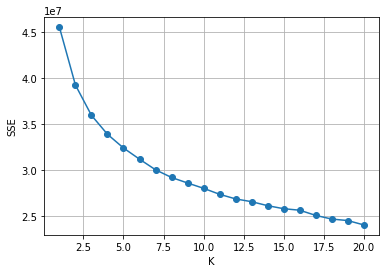

In [101]:
plt.plot(clusters, scores, linestyle='-', marker='o')
plt.xlabel('K')
plt.ylabel('SSE')
plt.grid()
plt.show();

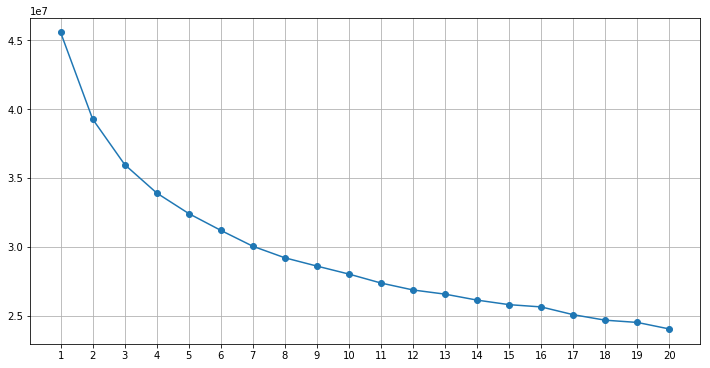

In [102]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(12,6))
k_ct = len(clusters)
x_ticks = np.arange(1, k_ct+1,1)
plt.plot(x_ticks, scores, linestyle='-', marker='o')
plt.xticks(x_ticks)
plt.grid()
plt.show();

In [103]:
# quick test
np.arange(1, len(scores))

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])

In [104]:
score_decrease = [0]
for i in np.arange(1, len(scores)):
    decrease = abs(scores[i] - scores[(i-1)])
    score_decrease.append(decrease)

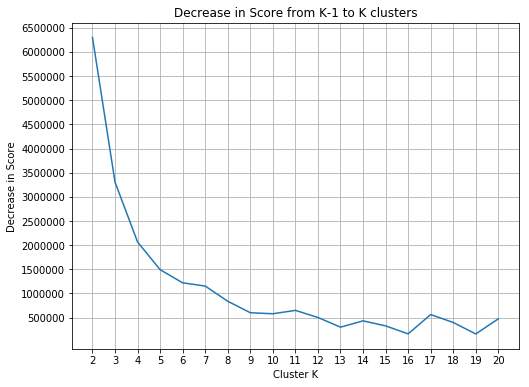

In [106]:
# To aid in identifying the elbow, we'll plot the decrease in scores across cluster sizes
plt.figure(figsize=(8,6))
plt.plot(np.arange(2, len(score_decrease)+1), score_decrease[1:20])
plt.xticks(np.arange(2, len(score_decrease)+1))
plt.yticks(np.arange(500000,7000000,500000))
plt.xlabel('Cluster K')
plt.ylabel('Decrease in Score')
plt.title('Decrease in Score from K-1 to K clusters')
plt.grid()

In [121]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
# from the Scree Plot above it looks like the elbow at clusters of size 7 is a reasonable choice of clusters
# Alternatively 11, 14 or 17 clusters also seems reasonable (local maxima)
kmeans = KMeans(n_clusters=7, random_state=0)
model_7 = kmeans.fit(azdias_pca)
azdias_preds = model_7.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [122]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [123]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# preprocessing of data
cust_clean = clean_data(customers)

# Imputing missing values
# Use existing imputer (so as not to exaggerate skews in the data)
cust_impute = pd.DataFrame(imp.transform(cust_clean))
cust_impute.columns = cust_clean.columns

# Scaling
# Use existing scaler to transform
cust_scaled = pd.DataFrame(scaler.transform(cust_impute))
cust_scaled.columns = cust_impute.columns

# feature transformation using existing pca decomposition
cust_pca = pca_32.transform(cust_scaled)


In [124]:
# clustering prediction using existing fitted model for hyperparameter of 12 clusters
cust_preds = model_7.predict(cust_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

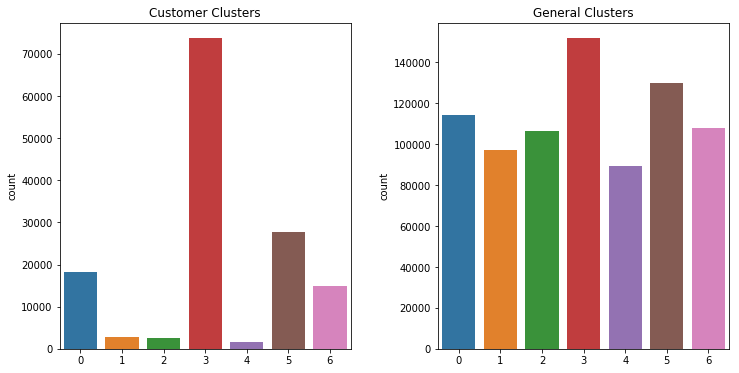

In [128]:
# To understand the cluster distributions, 
# we'll compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (12,6))
figure.subplots_adjust(hspace = 1, wspace=.3)

sns.countplot(cust_preds, ax=axs[0])
axs[0].set_title('Customer Clusters')
sns.countplot(azdias_preds, ax=axs[1])
axs[1].set_title('General Clusters');

In [125]:
# let's analyze using percents instead
cust_df = pd.DataFrame(cust_preds)
cust_df.columns = ['CLUSTER_COUNTS']
cust_pct = pd.DataFrame(cust_df.CLUSTER_COUNTS.value_counts())/cust_df.shape[0]*100
cust_pct.reset_index(inplace=True)
cust_pct.columns = ['CLUSTER', 'PERCENT']
cust_pct.head()

,CLUSTER,PERCENT
0,3,52.034724
1,5,19.509493
2,0,12.940927
3,6,10.588609
4,1,1.978262


In [127]:
# let's analyze using percents instead
azdias_df = pd.DataFrame(azdias_preds)
azdias_df.columns = ['CLUSTER_COUNTS']
azdias_pct = pd.DataFrame(azdias_df.CLUSTER_COUNTS.value_counts())/azdias_df.shape[0]*100
azdias_pct.reset_index(inplace=True)
azdias_pct.columns = ['CLUSTER', 'PERCENT']
azdias_pct.head()

,CLUSTER,PERCENT
0,3,19.039424
1,5,16.307634
2,0,14.346973
3,6,13.509160
4,2,13.367269


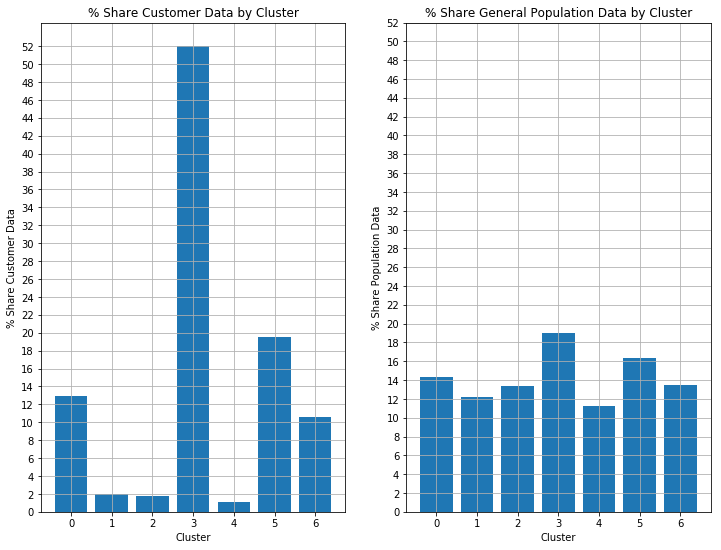

In [173]:
# we can recreate something similar to the earlier countplot distribution but instead 
# we'll plot the percentage shares via a bar chart
fig = plt.figure(figsize=(12,9))

pc_ct = len(cust_pct)
x_ticks = np.arange(0, pc_ct).astype('int')
ax1 = plt.subplot(1,2,1)
plt.bar(cust_pct['CLUSTER'], cust_pct['PERCENT'])
ax1.title.set_text("% Share Customer Data by Cluster")
plt.xlabel("Cluster")
plt.ylabel("% Share Customer Data")
plt.xticks(x_ticks)
plt.yticks(np.arange(0, 54, 2))
plt.grid()

pc_ct = len(azdias_pct)
x_ticks = np.arange(0, pc_ct).astype('int')
ax2 = plt.subplot(1,2,2)
plt.bar(azdias_pct['CLUSTER'], azdias_pct['PERCENT'])
ax2.title.set_text("% Share General Population Data by Cluster")
plt.xlabel("Cluster")
plt.ylabel("% Share Population Data")
plt.xticks(x_ticks)
plt.yticks(np.arange(0, 54, 2))
plt.grid()
plt.show();

In [149]:
# We'll use inverse_transformation to better understand the overrepresented and under-represented clusters
centroid_over = scaler.inverse_transform(pca_32.inverse_transform(model_7.cluster_centers_[3]))
overrep_c = pd.Series(data = centroid_over, index = cust_clean.columns)
overrep_c.head()

ALTERSKATEGORIE_GROB    1.753628
ANREDE_KZ               1.070544
FINANZ_MINIMALIST       4.611965
FINANZ_SPARER           1.778603
FINANZ_VORSORGER        4.099756
dtype: float64

In [152]:
overrep_c['WEALTH']

2.3162928165032897

In [182]:
centroid_under = scaler.inverse_transform(pca_32.inverse_transform(model_7.cluster_centers_[4]))
underrep_c = pd.Series(data = centroid_under, index = cust_clean.columns)
underrep_c.head()

ALTERSKATEGORIE_GROB    3.264188
ANREDE_KZ               1.966532
FINANZ_MINIMALIST       1.195167
FINANZ_SPARER           4.284564
FINANZ_VORSORGER        2.221598
dtype: float64

In [183]:
underrep_c['WEALTH']
# It appears overrepresented populations tend to be less wealthy

4.3672879069745001

In [184]:
# Given the large number of features, we'll compare ratios compared to the population and of each dataset
cust_compare = pd.DataFrame(overrep_c, columns=['overrep'])
cust_compare['underrep']= underrep_c

In [185]:
cust_compare['over_under_ratio'] = cust_compare['overrep']/cust_compare['underrep']

In [187]:
cust_compare['pop_mean'] = azdias_impute.mean()

In [188]:
cust_compare['overrep_pop_mean_ratio']=cust_compare['overrep']/cust_compare['pop_mean']

In [189]:
cust_compare['underrep_pop_mean_ratio']=cust_compare['underrep']/cust_compare['pop_mean']

In [190]:
top_over_under_ratio = cust_compare.sort_values(by=['over_under_ratio', 'overrep'], ascending=False).head(15).index.tolist()
top_over_pop_ratio = cust_compare.sort_values(by=['overrep_pop_mean_ratio', 'overrep'], ascending=False).head(15).index.tolist()

In [191]:
top_over_under_ratio

['GREEN_AVANTGARDE',
 'KBA05_ANTG1',
 'FINANZ_MINIMALIST',
 'SEMIO_VERT',
 'MOBI_REGIO',
 'PLZ8_ANTG1',
 'KBA05_GBZ',
 'FINANZ_VORSORGER',
 'KONSUMNAEHE',
 'INNENSTADT',
 'BALLRAUM',
 'SEMIO_LUST',
 'SEMIO_SOZ',
 'PLZ8_GBZ',
 'RETOURTYP_BK_S']

In [192]:
top_over_pop_ratio

['GREEN_AVANTGARDE',
 'KBA05_ANTG1',
 'FINANZ_MINIMALIST',
 'SEMIO_VERT',
 'MOBI_REGIO',
 'PLZ8_ANTG1',
 'KBA05_GBZ',
 'KONSUMNAEHE',
 'FINANZ_VORSORGER',
 'INNENSTADT',
 'SEMIO_KULT',
 'BALLRAUM',
 'SEMIO_FAM',
 'ANZ_PERSONEN',
 'SEMIO_SOZ']

In [227]:
# We'll align and cross-reference the two top lists for overrepresented customer populations 
# this will allow for a better picture of the overrepresented population as found in cluster 3
both_over = []
for item in top_over_under_ratio:
    if item in top_over_pop_ratio:
        both_over.append(item)
both_over        

['GREEN_AVANTGARDE',
 'KBA05_ANTG1',
 'FINANZ_MINIMALIST',
 'SEMIO_VERT',
 'MOBI_REGIO',
 'PLZ8_ANTG1',
 'KBA05_GBZ',
 'FINANZ_VORSORGER',
 'KONSUMNAEHE',
 'INNENSTADT',
 'BALLRAUM',
 'SEMIO_SOZ']

In [201]:
cust_compare.loc[['GREEN_AVANTGARDE',
 'KBA05_ANTG1',
 'FINANZ_MINIMALIST',
 'SEMIO_VERT',
 'MOBI_REGIO',
 'PLZ8_ANTG1',
 'KBA05_GBZ',
 'FINANZ_VORSORGER',
 'KONSUMNAEHE',
 'INNENSTADT',
 'BALLRAUM',
 'SEMIO_SOZ']]

,overrep,underrep,over_under_ratio,pop_mean,overrep_pop_mean_ratio,underrep_pop_mean_ratio
GREEN_AVANTGARDE,0.386025,0.039415,9.793884,0.219595,1.757896,0.179489
KBA05_ANTG1,2.415786,0.379305,6.368987,1.419553,1.701794,0.267200
FINANZ_MINIMALIST,4.611965,1.195167,3.858847,3.058878,1.507731,0.390721
SEMIO_VERT,6.009012,2.312949,2.597987,4.277417,1.404823,0.540735
MOBI_REGIO,3.922493,1.725720,2.272960,2.865350,1.368940,0.602272
PLZ8_ANTG1,2.882930,1.459660,1.975070,2.245998,1.283586,0.649894
KBA05_GBZ,4.037008,2.138498,1.887778,3.150650,1.281326,0.678748
FINANZ_VORSORGER,4.099756,2.221598,1.845408,3.432949,1.194237,0.647140
KONSUMNAEHE,3.793472,2.075049,1.828136,3.022872,1.254923,0.686450
INNENSTADT,5.433404,3.282862,1.655082,4.549698,1.194234,0.721556


In [196]:
cust_compare.sort_values(by=['over_under_ratio'], ascending=False).head(10)

,overrep,underrep,over_under_ratio,pop_mean,overrep_pop_mean_ratio,underrep_pop_mean_ratio
GREEN_AVANTGARDE,0.386025,0.039415,9.793884,0.219595,1.757896,0.179489
KBA05_ANTG1,2.415786,0.379305,6.368987,1.419553,1.701794,0.267200
FINANZ_MINIMALIST,4.611965,1.195167,3.858847,3.058878,1.507731,0.390721
SEMIO_VERT,6.009012,2.312949,2.597987,4.277417,1.404823,0.540735
MOBI_REGIO,3.922493,1.725720,2.272960,2.865350,1.368940,0.602272
PLZ8_ANTG1,2.882930,1.459660,1.975070,2.245998,1.283586,0.649894
KBA05_GBZ,4.037008,2.138498,1.887778,3.150650,1.281326,0.678748
FINANZ_VORSORGER,4.099756,2.221598,1.845408,3.432949,1.194237,0.647140
KONSUMNAEHE,3.793472,2.075049,1.828136,3.022872,1.254923,0.686450
INNENSTADT,5.433404,3.282862,1.655082,4.549698,1.194234,0.721556


In [197]:
cust_compare.sort_values(by=['overrep_pop_mean_ratio'], ascending=False).head(10)

,overrep,underrep,over_under_ratio,pop_mean,overrep_pop_mean_ratio,underrep_pop_mean_ratio
GREEN_AVANTGARDE,0.386025,0.039415,9.793884,0.219595,1.757896,0.179489
KBA05_ANTG1,2.415786,0.379305,6.368987,1.419553,1.701794,0.267200
FINANZ_MINIMALIST,4.611965,1.195167,3.858847,3.058878,1.507731,0.390721
SEMIO_VERT,6.009012,2.312949,2.597987,4.277417,1.404823,0.540735
MOBI_REGIO,3.922493,1.725720,2.272960,2.865350,1.368940,0.602272
PLZ8_ANTG1,2.882930,1.459660,1.975070,2.245998,1.283586,0.649894
KBA05_GBZ,4.037008,2.138498,1.887778,3.150650,1.281326,0.678748
KONSUMNAEHE,3.793472,2.075049,1.828136,3.022872,1.254923,0.686450
FINANZ_VORSORGER,4.099756,2.221598,1.845408,3.432949,1.194237,0.647140
INNENSTADT,5.433404,3.282862,1.655082,4.549698,1.194234,0.721556


In [220]:
# Now we'll do a similar analysis but instead for the underrepresented populations
# first lets get a list of those underrepresented individuals with the largest ratio when 
# compared to the general population
top_under_pop_ratio = cust_compare.sort_values(by=['underrep_pop_mean_ratio', 'underrep'], ascending=False).head(15).index.tolist()
cust_compare.sort_values(by=['underrep_pop_mean_ratio', 'underrep'], ascending=False).head(10)

,overrep,underrep,over_under_ratio,pop_mean,overrep_pop_mean_ratio,underrep_pop_mean_ratio
KBA05_ANTG4,0.018505,0.635042,0.029139,0.290628,0.063671,2.185065
KBA05_ANTG3,0.110199,1.130499,0.097479,0.593295,0.185741,1.905458
PLZ8_ANTG4,0.234071,1.286562,0.181935,0.678934,0.344762,1.894973
ANZ_HAUSHALTE_AKTIV,2.012649,15.160816,0.132753,8.297020,0.242575,1.827260
ANZ_HH_TITEL,0.012724,0.064810,0.196321,0.040455,0.314507,1.602007
FINANZ_SPARER,1.778603,4.284564,0.415119,2.715918,0.654881,1.577575
SEMIO_RAT,2.744189,5.999125,0.457432,3.893733,0.704771,1.540713
PLZ8_ANTG3,0.949236,2.421847,0.391947,1.607136,0.590638,1.506934
ALTERSKATEGORIE_GROB,1.753628,3.264188,0.537233,2.203880,0.795700,1.481109
SEMIO_PFLICHT,3.338491,6.179997,0.540209,4.184413,0.797840,1.476909


In [221]:
# Now lets get a list of those underrepresented individuals with the largest ratio when 
# compared to the overrepresented population
top_under_over_ratio = cust_compare.sort_values(by=['over_under_ratio', 'overrep'], ascending=True).head(15).index.tolist()
cust_compare.sort_values(by=['over_under_ratio', 'overrep'], ascending=True).head(10)

,overrep,underrep,over_under_ratio,pop_mean,overrep_pop_mean_ratio,underrep_pop_mean_ratio
KBA05_ANTG4,0.018505,0.635042,0.029139,0.290628,0.063671,2.185065
KBA05_ANTG3,0.110199,1.130499,0.097479,0.593295,0.185741,1.905458
ANZ_HAUSHALTE_AKTIV,2.012649,15.160816,0.132753,8.297020,0.242575,1.827260
PLZ8_ANTG4,0.234071,1.286562,0.181935,0.678934,0.344762,1.894973
ANZ_HH_TITEL,0.012724,0.064810,0.196321,0.040455,0.314507,1.602007
PLZ8_ANTG3,0.949236,2.421847,0.391947,1.607136,0.590638,1.506934
FINANZ_SPARER,1.778603,4.284564,0.415119,2.715918,0.654881,1.577575
SEMIO_KAEM,2.608260,6.009215,0.434043,4.294280,0.607380,1.399353
SEMIO_RAT,2.744189,5.999125,0.457432,3.893733,0.704771,1.540713
FINANZ_HAUSBAUER,1.978613,4.170626,0.474416,3.114560,0.635279,1.339074


In [223]:
top_under_over_ratio

['KBA05_ANTG4',
 'KBA05_ANTG3',
 'ANZ_HAUSHALTE_AKTIV',
 'PLZ8_ANTG4',
 'ANZ_HH_TITEL',
 'PLZ8_ANTG3',
 'FINANZ_SPARER',
 'SEMIO_KAEM',
 'SEMIO_RAT',
 'FINANZ_HAUSBAUER',
 'FINANZ_ANLEGER',
 'WEALTH',
 'SEMIO_DOM',
 'ALTERSKATEGORIE_GROB',
 'SEMIO_PFLICHT']

In [224]:
top_under_pop_ratio

['KBA05_ANTG4',
 'KBA05_ANTG3',
 'PLZ8_ANTG4',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'FINANZ_SPARER',
 'SEMIO_RAT',
 'PLZ8_ANTG3',
 'ALTERSKATEGORIE_GROB',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'FINANZ_ANLEGER',
 'SEMIO_KAEM',
 'FINANZ_UNAUFFAELLIGER',
 'SEMIO_REL']

In [225]:
# now let's cross reference the two to get a top list of features for 
# underrepresnted populations as found in cluster 4
both_under = []
for item in top_under_over_ratio:
    if item in top_under_pop_ratio:
        both_under.append(item)
both_under  

['KBA05_ANTG4',
 'KBA05_ANTG3',
 'ANZ_HAUSHALTE_AKTIV',
 'PLZ8_ANTG4',
 'ANZ_HH_TITEL',
 'PLZ8_ANTG3',
 'FINANZ_SPARER',
 'SEMIO_KAEM',
 'SEMIO_RAT',
 'FINANZ_ANLEGER',
 'ALTERSKATEGORIE_GROB',
 'SEMIO_PFLICHT']

In [228]:
both_over

['GREEN_AVANTGARDE',
 'KBA05_ANTG1',
 'FINANZ_MINIMALIST',
 'SEMIO_VERT',
 'MOBI_REGIO',
 'PLZ8_ANTG1',
 'KBA05_GBZ',
 'FINANZ_VORSORGER',
 'KONSUMNAEHE',
 'INNENSTADT',
 'BALLRAUM',
 'SEMIO_SOZ']

In [229]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# for the overrepresnted population we find that:
# These customers tend to reside in rural areas that are far from dense city centers/stores/point of sales, 
#as captured by relatively high scores for the following 3 features when compared with both 
# the general population and the underrepresented group:
# KONSUMNAEHE (Distance from building to point of sale (PoS))
#INNENSTADT (Distance to city center (downtown)).
# BALLRAUM (Distance to nearest urban center)

# These customers tend to live in more single family type homes as is captured per relatively high scores for 
# the features KBA05_ANTG1 and PLZ8_ANTG1 which represents a relatively high number of 1-2 family homes in 
# the ANTG1 microcell and plaza respectively. This makes sense as large multi-family homes are more typical 
# in urban cities.

# These customers do not tend to move often as exhibted by relatively high scores for the feature of
# MOBI_REGIO = Movement patterns (higher score means less movement)

# These segments of overrepresented customers makes sense given the fact that we are attempting to 
# identify customers for a 'mail-order' sales - hence if it's hard to shop in-person at a far away city store
# or opportunities are otherwise infrequent, then mail-order sales would be very beneficial to such customers.  
# Lastly we find such customers have low-affinity with identifying theselves as having 
# low financial interest or as savers as exhibited by relatively high scores for features 
# FINANZ_MINIMALIST and FINANZ_VORSORGER respectively 
# (the higher the score the lower identification with said financial typology)

In [230]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
# These customers tend to reside in dense urban areas as exhibited by relatively high values for the number of 
# 10+ family homes in the 'ANTG4' microcell and ANTG4 Plaza as captured in features KBA05_ANTG4 and  PLZ8_ANTG4  
# respectively.  This population similarly has relatively high values of 6-10 family homes in the ANTG3 microcell 
# as captured in feature KBA05_ANTG3.  
# This population also appears to be of a younger age generally, which makes sense as younger people tend to migrate
# to urban areas and live in smaller multi-family dwellings like apartments
# (as per my data cleanup step to reverse the direction of scale ALTERSKATEGORIE_GROB, a higher value for that
# feature means a younger age.  In addition, this population tends to have more professional academic title holders 
# in building as per feature 'ANZ_HH_TITEL', which is inline with the concept of younger more educated professionals 
# in urban areas and or even college dormitories.
# Lastly, this population tends to have low affinity with identifying themselves as 'money savers', or of having
# personality typologies of 'combative', 'rational', and 'dutiful'.


### Discussion 3.3: Compare Customer Data to Demographics Data

**Popular segments of customers**
Segments of the population that are relatively popoular with the mail-order company tend to reside in rural areas that are far from dense city centers/stores/point of sales, as captured by relatively high scores for the following 3 features when compared with both the general population and the underrepresented group:
- KONSUMNAEHE (Distance from building to point of sale (PoS))
- INNENSTADT (Distance to city center (downtown)).
- BALLRAUM (Distance to nearest urban center)
 These customers tend to live in more single family type homes as is captured per relatively high scores for the features KBA05_ANTG1 and PLZ8_ANTG1 which represents a relatively high number of 1-2 family homes in the ANTG1 microcell and plaza respectively. This makes sense as large multi-family homes are more typical in urban cities.
These customers do not tend to move often as exhibted by relatively high scores for the feature of 'MOBI_REGIO' = Movement patterns (higher score means less movement)
These overrepresented segments of customers make sense given the fact that we are attempting to identify customers for 'mail-order' sales - hence if it's hard to shop in-person at a far away city store or opportunities are otherwise infrequent, then mail-order sales would be very beneficial to such customers.  Lastly we find such customers have low-affinity with identifying theselves as having low financial interest or as savers as exhibited by relatively high scores for features  FINANZ_MINIMALIST and FINANZ_VORSORGER respectively (the higher the score the lower identification with said financial typology)

**Unpopular segments of customers**
Segments of the population that are relatively unpopular with the mail-order company tend to reside in dense urban areas as exhibited by relatively high values for the number of 10+ family homes in the 'ANTG4' microcell and ANTG4 Plaza as captured in features KBA05_ANTG4 and  PLZ8_ANTG4 respectively.  This population similarly has relatively high values of 6-10 family homes in the ANTG3 microcell as captured in feature KBA05_ANTG3.  
This population also appears to be of a younger age generally, which makes sense as younger people tend to migrate
to urban areas and live in smaller multi-family dwellings like apartments (as per my data cleanup step to reverse the direction of scale ALTERSKATEGORIE_GROB, a higher value for that feature means a younger age.  In addition, this population tends to have more professional academic title holders in building as per feature 'ANZ_HH_TITEL', which is inline with the concept of younger more educated professionals in urban areas and or even college dormitories. Lastly, this population tends to have low affinity with identifying themselves as 'money savers', or of having
personality typologies of 'combative', 'rational', and 'dutiful'.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.